# Import libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin
import pickle

In [3]:
import statsmodels.api as sm

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.metrics import r2_score

from sklearn.inspection import permutation_importance
import shap

In [5]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

from stats_utils import *

# Import Data

In [6]:
with open("../data/processed/processed_data_and_desc.pkl", "rb") as f:
    data = pickle.load(f)
df = data['df_diabetes_processed']
column_long_name = data['col_desc']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       442 non-null    int64   
 1   sex       442 non-null    int64   
 2   bmi       442 non-null    float64 
 3   bp        442 non-null    float64 
 4   tc        442 non-null    int64   
 5   ldl       442 non-null    float64 
 6   hdl       442 non-null    float64 
 7   tch       442 non-null    float64 
 8   ltg       442 non-null    float64 
 9   glu       442 non-null    int64   
 10  y         442 non-null    int64   
 11  bmi_cat   442 non-null    category
 12  bmi_log   442 non-null    float64 
 13  bmi_cat2  442 non-null    category
 14  is_obese  442 non-null    int64   
dtypes: category(2), float64(7), int64(6)
memory usage: 46.0 KB


In [8]:
column_long_name

{'age': 'age',
 'sex': 'sex',
 'bmi': 'body_mass_index',
 'bp': 'average_blood_pressure',
 'tc': 'total_cholesterol',
 'ldl': 'low_density_lipoproteins',
 'hdl': 'high_density_lipoproteins',
 'tch': 'total_cholesterol/HDL',
 'ltg': 'log_of_triglycerides_level',
 'glu': 'glucose',
 'y': 'progression_y'}

In [9]:
original_variables = list(df.columns[0:10])
processed_variables = list(df.columns[12:])
target = ['y']

# Multivariate analysis

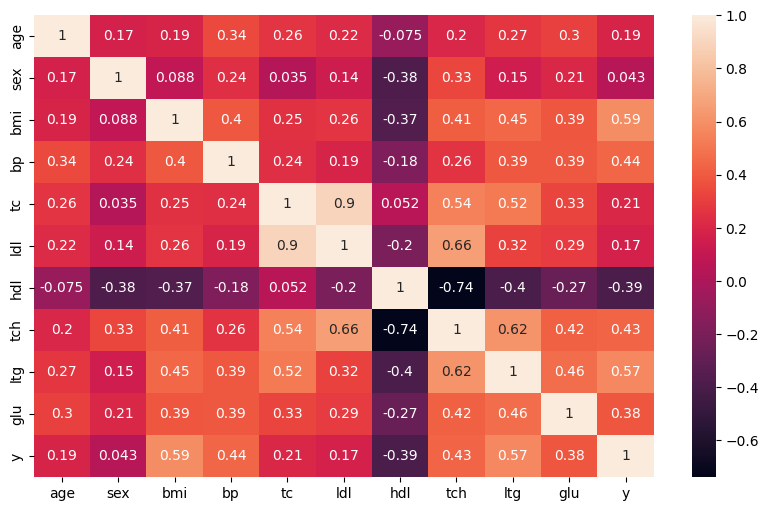

In [10]:
# Linear correlation
data = pd.get_dummies(df[original_variables + target])
corr_matrix = data.corr(method='pearson')
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [11]:
corr_matrix[['y']].abs().sort_values(by='y')

,y
sex,0.043062
ldl,0.174054
age,0.187889
tc,0.212022
glu,0.382483
hdl,0.394789
tch,0.430453
bp,0.441482
ltg,0.565883
bmi,0.586450


In [12]:
# Select the highest correlation (> 0.70 or <-0.70)
mask = np.triu(np.ones(corr_matrix.shape)).astype(bool) # Filter to select the upper triangle of the matrix
corr_matrix_melt = corr_matrix.mask(mask).stack().reset_index()
corr_matrix_melt.columns =['variable_1','variable_2','correlation']
corr_matrix_melt['abs_correlation'] = abs(corr_matrix_melt['correlation'])
corr_matrix_melt[abs(corr_matrix_melt['correlation']) > 0.70]

,variable_1,variable_2,correlation,abs_correlation
14,ldl,tc,0.896663,0.896663
27,tch,hdl,-0.738493,0.738493


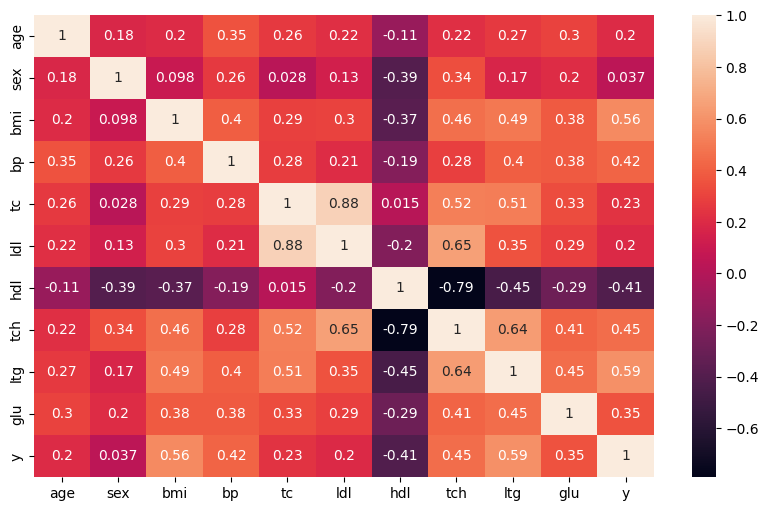

In [13]:
# Non Linear correlation
data = pd.get_dummies(df[original_variables + target])
corr_matrix = data.corr(method='spearman')
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [14]:
select_highest_correlation(corr_matrix)

,variable_1,variable_2,correlation,abs_correlation
14,ldl,tc,0.878793,0.878793
27,tch,hdl,-0.789694,0.789694


Whatever the method (Pearson or Spearman), the two most correlated variables are:
- ldl and tc
- tch and hld

What's more, I don't see any drastic change between inputs and targets when moving from linear to non-linear correlation.

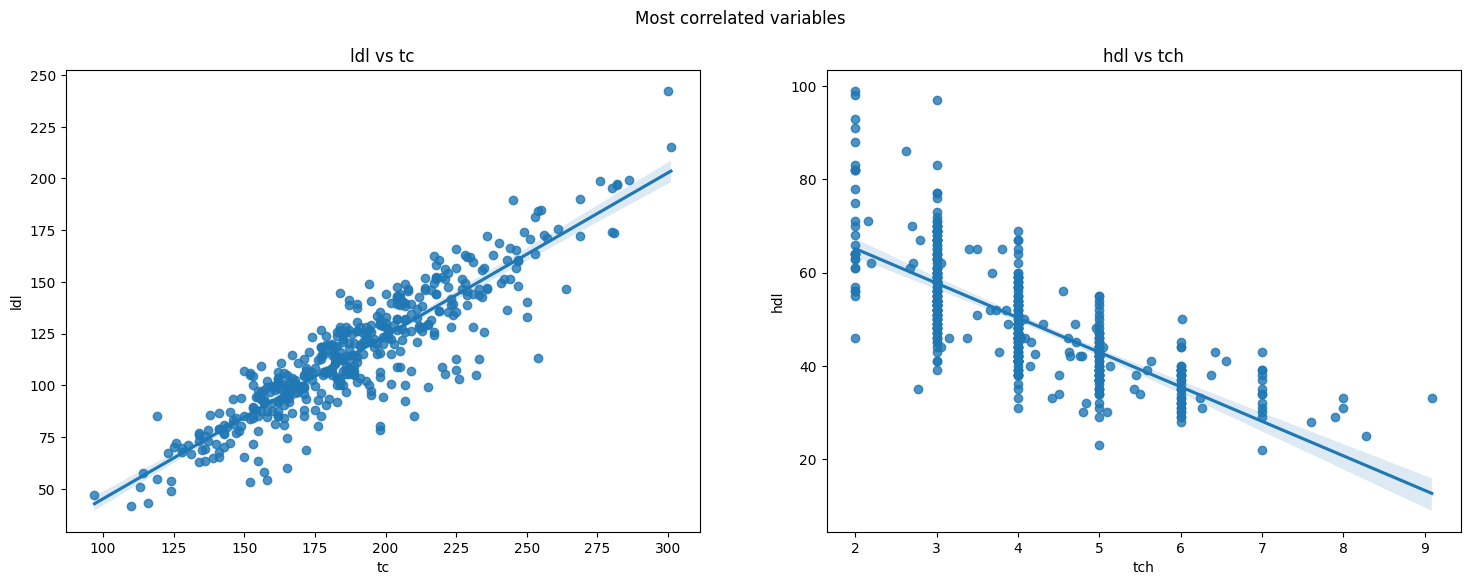

In [15]:
# Visualise the correlation
fig, axes = plt.subplots(1,2, figsize=(18,6))

sns.regplot(x='tc',y='ldl', data=df, ax=axes[0])
sns.regplot(x='tch',y='hdl', data=df, ax=axes[1])

axes[0].set_title("ldl vs tc")
axes[1].set_title("hdl vs tch")
plt.suptitle("Most correlated variables")
plt.show()

- We could almost predict the level of bad cholesterol (ldl: low_density_lipoproteins) according to the level of cholestorel, tc, in diabetics, as there is clearly a linear relationship

In [16]:
# The variable tch is described as the ratio between TC and HDL.
# Calculate the difference between the manually calculated ratio tc/hdl and TCL
abs((df['tc']/df['hdl']) - df['tch']).describe()

count    442.000000
mean       0.208381
std        0.162566
min        0.000000
25%        0.057378
50%        0.194783
75%        0.333333
max        0.645161
dtype: float64

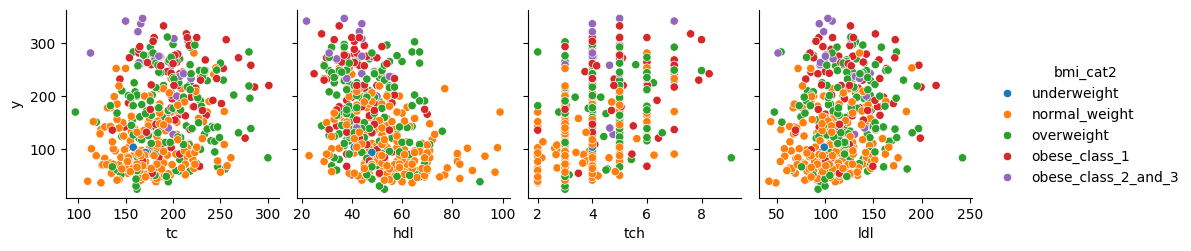

In [17]:
# Visualize the correlation of all variable with the progression
some_variable = ['tc','hdl','tch','ldl']
sns.pairplot(df, x_vars=some_variable, y_vars='y', hue='bmi_cat2')
plt.show()

In [18]:
# Colinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Select predictors variables 
X = df[original_variables]
#X.drop(columns=['transaction_date'], inplace = True)

# transform data
X = pd.get_dummies(X, drop_first=True)
bool_var = X.select_dtypes(include=['bool']).columns
X[bool_var] = X[bool_var].astype(int)

X = X.dropna()
# Add constant (if needed)
X = add_constant(X)
X.columns


Index(['const', 'age', 'sex', 'bmi', 'bp', 'tc', 'ldl', 'hdl', 'tch', 'ltg',
       'glu'],
      dtype='object')

In [19]:
# Check VIF can be performed correctly 
print(X.isnull().sum().sum())  # Check nan values
print(X.isna().sum().sum())
print(np.isinf(X).sum().sum())  # Check infinite values
print("Constant columns: \n", X.nunique()[X.nunique() <2]) # Check the constant columns
print("Boolean columns: \nn", X.select_dtypes(include=['bool']).columns) # Check if there is bool columns 


0
0
0
Constant columns: 
 const    1
dtype: int64
Boolean columns: 
n Index([], dtype='object')


In [20]:
# Calculate the vif for each feature
data_vif = pd.DataFrame()
data_vif['Feature'] = X.columns
data_vif['Value'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
data_vif

,Feature,Value
0,const,677.734319
1,age,1.217307
2,sex,1.278071
3,bmi,1.509437
4,bp,1.459428
5,tc,59.202510
6,ldl,39.193370
7,hdl,15.402156
8,tch,8.890986
9,ltg,10.075967


**VIF analysis**

In [21]:
# Vif analysis
vif_analysis(df, original_variables)

df shape:  (442, 10)
df initial variables:  ['age', 'sex', 'bmi', 'bp', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']
Selected variable for the vif analysis  ['const', 'age', 'sex', 'bmi', 'bp', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']

Sanity check: 
	 Null values:  0
	 Nan values:  0
	 infinite values:  0
	 Constant columns: ['const']
	 Boolean columns: []


,Feature,Value
0,const,677.734319
1,age,1.217307
2,sex,1.278071
3,bmi,1.509437
4,bp,1.459428
5,tc,59.202510
6,ldl,39.193370
7,hdl,15.402156
8,tch,8.890986
9,ltg,10.075967


The variables tc, ldl, hdl and ltg have a VIF > 10.
- Among these variables, I decide to delete 'ldl' because it is the least correlated with the target y (corr=0.20) and because it has too strong a correlation with 'hdl' r('ldl','hdl') = 0.897

In [22]:
# Drop one column to avoid colinearity
X = df[original_variables].copy()
X = X.drop(columns=["ldl"]) #Drop one column to avoid colinearity
vif_analysis(X, X.columns)

df shape:  (442, 9)
df initial variables:  ['age', 'sex', 'bmi', 'bp', 'tc', 'hdl', 'tch', 'ltg', 'glu']
Selected variable for the vif analysis  ['const', 'age', 'sex', 'bmi', 'bp', 'tc', 'hdl', 'tch', 'ltg', 'glu']

Sanity check: 
	 Null values:  0
	 Nan values:  0
	 infinite values:  0
	 Constant columns: ['const']
	 Boolean columns: []


,Feature,Value
0,const,265.622815
1,age,1.215191
2,sex,1.275784
3,bmi,1.496155
4,bp,1.458635
5,tc,4.420601
6,hdl,6.562825
7,tch,8.726158
8,ltg,2.091866
9,glu,1.484242


All variables now have a vif < 10, but there are still 'high' vif for linear model use.
- Notably the variables tc, hdl and tch, which is expected as tch is approximately equal to the tc/hdl ratio.

In [23]:
#Drop one column to avoid colinearity
X = df[original_variables].copy()

X = X.drop(columns=['ldl','tch']) #Drop one column to avoid colinearity
vif_analysis(X, X.columns)

df shape:  (442, 8)
df initial variables:  ['age', 'sex', 'bmi', 'bp', 'tc', 'hdl', 'ltg', 'glu']
Selected variable for the vif analysis  ['const', 'age', 'sex', 'bmi', 'bp', 'tc', 'hdl', 'ltg', 'glu']

Sanity check: 
	 Null values:  0
	 Nan values:  0
	 infinite values:  0
	 Constant columns: ['const']
	 Boolean columns: []


,Feature,Value
0,const,198.973592
1,age,1.214683
2,sex,1.268551
3,bmi,1.494191
4,bp,1.447232
5,tc,1.598187
6,hdl,1.667016
7,ltg,2.083192
8,glu,1.477121


- After removing the 'ldl' and 'tch' variables, all vif are well below < 10

**Correlation analysis between categorical variables and the target y**

In [24]:
# Find the categorical variables:
df.select_dtypes(include=['object','category']).columns 

Index(['bmi_cat', 'bmi_cat2'], dtype='object')

- As we saw earlier, there is a significant difference between bmi_cat2 and y. So I should keep this variable.
- _And as a reminder, bmi_cat is the variable categorized by the bmi into ‘official’ classes, but in our dataset, as some categories have too few members, we concatenated some modalities in order to perform statistical tests, so this variable is only useful from an explicability point of view._

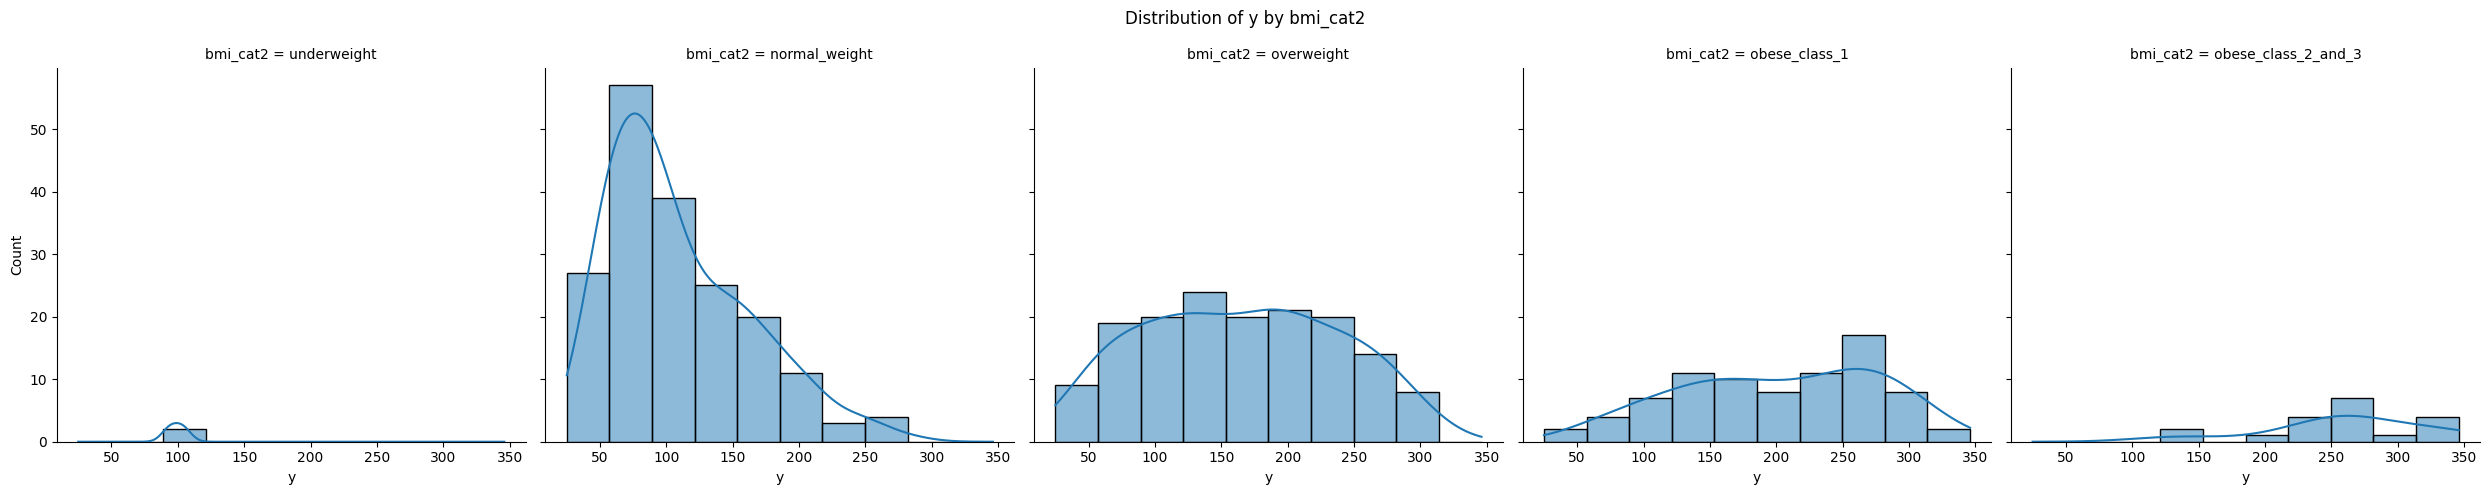

** Shapiro Test**

                groups  statistic  p value
0          underweight        NaN      NaN
1        normal_weight     0.9204   0.0000
2           overweight     0.9706   0.0021
3        obese_class_1     0.9627   0.0196
4  obese_class_2_and_3     0.9272   0.1537 

For at least one group the p_value < alpha = 0.01, so we reject the null hypothesis and the y distribution is not normal within the groups

** Test equality of variance - Levene test**

p_value < alpha = 0.01, so we reject the null hypothesis and the variances of y within the groups are not equals


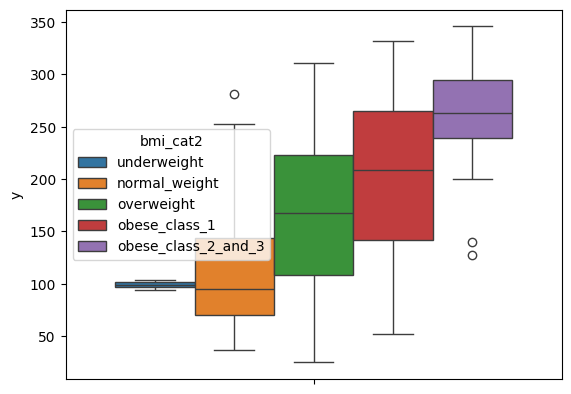

,bmi_cat2,mean,std
0,underweight,99.0,7.1
1,normal_weight,109.4,52.8
2,overweight,165.0,73.0
3,obese_class_1,202.1,73.5
4,obese_class_2_and_3,260.8,59.6


In [25]:
# Check hypothesis 
from stats_utils import check_normality_by_group, check_levene_by_group
# settings
alpha = 0.01
variable = 'y'
var_group = 'bmi_cat2'
group_list = [ df[df[var_group] == cat][variable] for cat in  df[var_group].cat.categories]

# perform check
check_normality_by_group(df, variable, var_group)
check_levene_by_group(df, variable, var_group, alpha=0.01)

# EDA 
eda_for_anova(df, variable, var_group)

In [26]:
pingouin.kruskal(data=df, dv=variable, between=var_group)

,Source,ddof1,H,p-unc
Kruskal,bmi_cat2,4,123.728855,8.531502e-26


Since the p_value < 0.05, we reject the null hypothesis and conclude that there is a significant difference between the groups. And so I keep this variable in the model

**But, What to choose between bmi, bmi_log and bmi_cat2 ?**

-> Objective: keep **only one version of BMI** to avoid redundancy and collinearity.
**Priori**
- I think we can already eliminate the categorical variable 'bmi_cat2', because when you categorize a variable you lose information and in particular the linear relationship that we've observed between bmi and y. So keeping bmi_cat2 would not be a good choice.

Now there's the question of bmi versus bmi_log, and I think it's preferable to keep the 'bmi' variable, however:
- I think a simple correlation calculation between y and the two variables will allow us to decide which one to keep.
- Moreover, we can also train a simple regression model with each of the variables and keep the one with the best metrics.

In [27]:
# Correlation 
df[['bmi','bmi_log','y']].corr()

,bmi,bmi_log,y
bmi,1.000000,0.994751,0.586450
bmi_log,0.994751,1.000000,0.581645
y,0.586450,0.581645,1.000000


- bmi and bmi_log have approximately the same linear correlation coefficient with y, respectively 0.586 and 0.582
- At this stage, I can conclude that I should keep only bmi, because: although the results are very similar, bmi has a greater linear correlation with the target variable. Then, with r equal, I might as well keep the least transformed variable

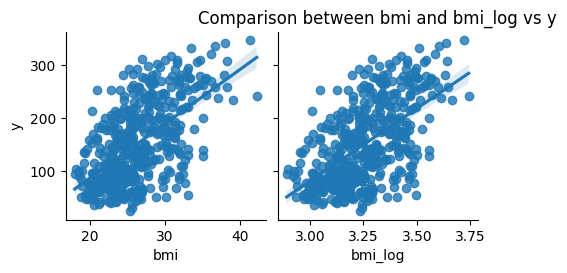

In [28]:
sns.pairplot( df, x_vars=["bmi", "bmi_log"], y_vars=["y"], kind='reg')
plt.title("Comparison between bmi and bmi_log vs y")
plt.show()

To determine which variable to keep, we'll run simple linear regression models with a single variable and compare the results of the 3 models.

In [29]:
# Comparaison of the 3 simple linear regressions
from statsmodels.formula.api import ols

model1 = ols("y ~ bmi", data= df).fit()
model2 = ols("y ~ bmi_log", data=df).fit()
model3 = ols("y ~ bmi_cat2 + 0", data=df).fit()

print("\n y vs bmi")
print(model1.params)
print(f"\t r_squared = {model1.rsquared}")
print(f"\t Residual Standar Error rse = {np.sqrt(model1.mse_resid)}")

print("\n y vs bmi_log")
print(model2.params)
print(f"\t bmi_log: r_squared = {model2.rsquared}")
print(f"\t bmi: Residual Standar Error rse = {np.sqrt(model2.mse_resid)}")

print("\n y vs bmi_categ")
print(model3.params)
print(f"\t  bmi_categ: r_squared = {model3. rsquared}")
print(f"\t Residual Standar Error rse = {np.sqrt(model3.mse_resid)}")


 y vs bmi
Intercept   -117.773367
bmi           10.233128
dtype: float64
	 r_squared = 0.3439237602253802
	 Residual Standar Error rse = 62.51512200285265

 y vs bmi_log
Intercept   -737.882996
bmi_log      273.106653
dtype: float64
	 bmi_log: r_squared = 0.3383111623143159
	 bmi: Residual Standar Error rse = 62.781954578571586

 y vs bmi_categ
bmi_cat2[underweight]             99.000000
bmi_cat2[normal_weight]          109.376344
bmi_cat2[overweight]             165.032258
bmi_cat2[obese_class_1]          202.075000
bmi_cat2[obese_class_2_and_3]    260.789474
dtype: float64
	  bmi_categ: r_squared = 0.30344187454426585
	 Residual Standar Error rse = 64.63566617702143


- The model with 'bmi' as the explanatory variable has the highest coefficient of determination and the lowest standard residual.
- I will therefore use the bmi variable in the linear regression model

**feature set**

In [30]:
# Final feature set 
remove_var = ['tch','ldl']
feature_set = [var for var in original_variables if var not in remove_var]
print(feature_set)

['age', 'sex', 'bmi', 'bp', 'tc', 'hdl', 'ltg', 'glu']


From this cleaned, colinearity-free set, we'll build our linear regression model.

# Inference and Statistical Modeling - Explanatory Model

In this section, we use the statsmodels.OLS module, which is better suited to statistical inference than Sklearn's LinearRegression, as it allows us to analyze the significance of coefficients (p-values, confidence intervals, global tests, etc.).
Inference is performed only on the training data to avoid any bias. 
The validity assumptions of linear regression (normality of residuals, homoscedasticity, independence) are also tested on the train set, as these are the parameters estimated on this set that we are seeking to validate.

## Linear Regression with OLS

**Can we model a relationship between progression y and indicators?**

In [31]:
import statsmodels.api as sm

X = df[feature_set]         # predictors variables 
X = sm.add_constant(X)      # add a constant for the regression line
y = df['y']                 # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rl_model = sm.OLS(y_train, X_train).fit()
print(rl_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     47.10
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           7.07e-51
Time:                        00:12:52   Log-Likelihood:                -1908.0
No. Observations:                 353   AIC:                             3834.
Df Residuals:                     344   BIC:                             3869.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -253.3692     40.296     -6.288      0.0

In [32]:
# Check the size of the Training set and testset 
print(f"Training set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")

Training set size: 353
Test set size: 89


In [33]:
# Metric of the train set 
y_pred_train = rl_model.fittedvalues
assert len(y_pred_train) == len(y_train)

print(f"Mean of squared residuals: {rl_model.mse_resid:.4f}")
print(f"r_squared =: {rl_model.rsquared:.4f}")
print(f"MAPE: {mape(y_train, y_pred_train):.4f}")
print(f"RMSE train = {mean_squared_error(y_train, rl_model.fittedvalues)**(1/2):.4f}")

Mean of squared residuals: 2975.8364
r_squared =: 0.5227
MAPE: 0.3911
RMSE train = 53.8513


In [34]:
# Metric of the test set 
y_pred = rl_model.predict(X_test)
assert len(y_pred) == len(y_test)

mape_test = mape(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred)**(1/2)

print(f"r_squared test = {r2:.4f}")
print(f"MAPE test = {mape(y_test, y_pred):.4f}")
print(f"RMSE test = {rmse_test:.4f}")

r_squared test = 0.4604
MAPE test = 0.3733
RMSE test = 53.4687


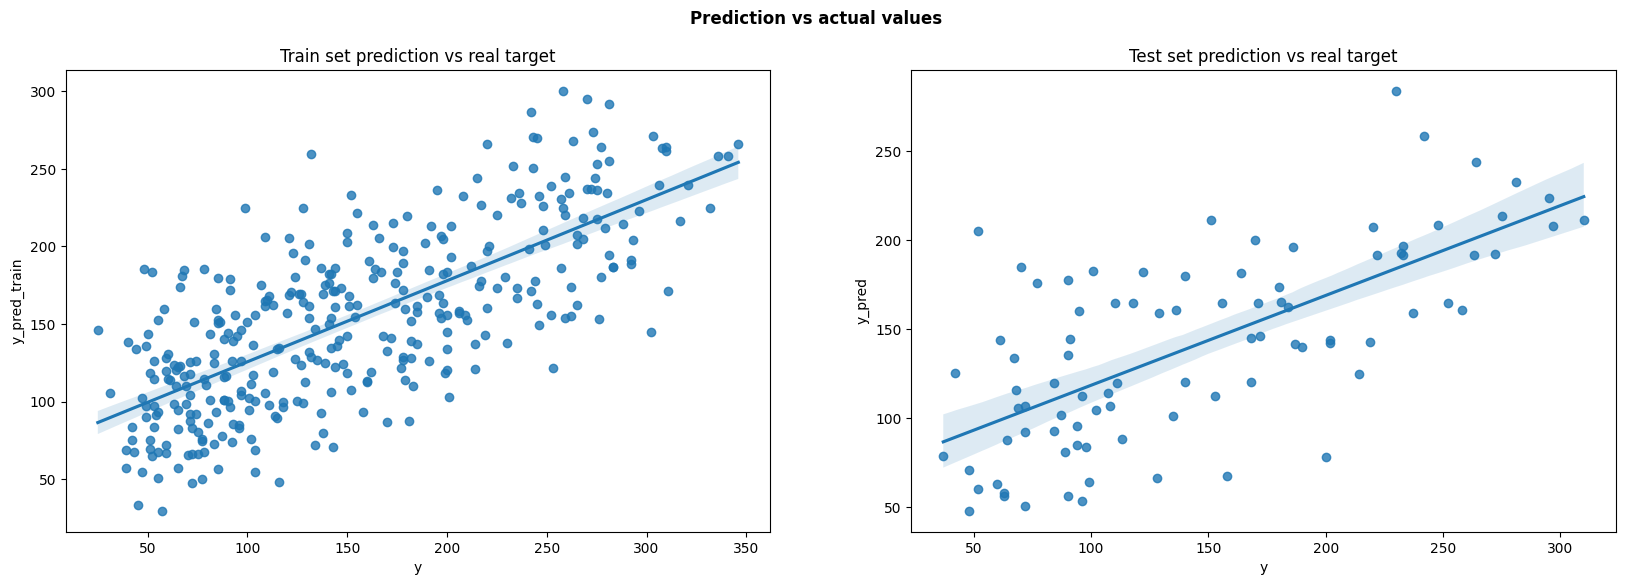

In [35]:
fig, axes = plt.subplots(1,2, figsize=(20,6))
# Data manipulation
df_result_training_set = pd.DataFrame({'y':y_train, 'y_pred_train': y_pred_train})
df_result_test_set = pd.DataFrame({'y':y_test, 'y_pred': y_pred})
# Visualization 
sns.regplot(x='y', y='y_pred_train', data = df_result_training_set, ax=axes[0])
sns.regplot(x='y', y='y_pred', data = df_result_test_set, ax=axes[1])

#axes[1].set_xlim(axes[0].get_xlim()) 
#axes[1].set_ylim(axes[0].get_ylim())
axes[0].set_title("Train set prediction vs real target")
axes[1].set_title("Test set prediction vs real target")

plt.suptitle("Prediction vs actual values", fontweight="bold")
plt.show()

- The coefficient of determination R2(full) varies from 0.523 during the training to 0.460 with the test set

## Backward Elimination

As we saw the p_values > 0.05, so we will remove them, to see if it increase the model performances

In [36]:
# Backward - 1. Removing age 
import statsmodels.api as sm

X = df[feature_set]         
X.drop(columns='age', inplace =True)
X = sm.add_constant(X)      
y = df['y']                 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rl_model = sm.OLS(y_train, X_train).fit()
print(rl_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     53.89
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           1.08e-51
Time:                        00:12:53   Log-Likelihood:                -1908.2
No. Observations:                 353   AIC:                             3832.
Df Residuals:                     345   BIC:                             3863.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -254.1341     40.231     -6.317      0.0

In [37]:
y_pred_train, y_pred = evaluate_ols_regression_model(rl_model, y_train, X_test, y_test)

***Metric of the train set***
Mean of squared residuals: 2969.8428
r_squared train = 0.5223
MAPE: 0.3912
RMSE train = 53.8752

***Metric of the test set***
r_squared test = 0.4661
MAPE test = 0.3727
RMSE test = 53.1874

The coefficient of determination R2 varies from 0.522 during the training to 0.466 with the test set


- The r2 score of the test set increased very slightly by removing the input variable 'age', from r2(full)=0.460 to r2(-age)=0.466.
- And as 'glu' still have a p_value > 0.05, I will remove it, to make sure all the coefficiants are significant and to see if it will improve the model

In [38]:
# Backward - 2. Removing age & glucose
import statsmodels.api as sm

X = df[feature_set]         
X.drop(columns=['age','glu'], inplace =True)
X = sm.add_constant(X)      
y = df['y']                 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rl_model = sm.OLS(y_train, X_train).fit()

residuals = rl_model.resid
y_pred = rl_model.fittedvalues

print(rl_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     62.80
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           1.88e-52
Time:                        00:12:53   Log-Likelihood:                -1908.6
No. Observations:                 353   AIC:                             3831.
Df Residuals:                     346   BIC:                             3858.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -243.5956     38.323     -6.356      0.0

In [39]:
y_pred_train, y_pred = evaluate_ols_regression_model(rl_model, y_train, X_test, y_test)

***Metric of the train set***
Mean of squared residuals: 2967.6644
r_squared train = 0.5213
MAPE: 0.3909
RMSE train = 53.9334

***Metric of the test set***
r_squared test = 0.4632
MAPE test = 0.3728
RMSE test = 53.3277

The coefficient of determination R2 varies from 0.521 during the training to 0.463 with the test set


- Now the coefficients are significant, but removing the glucose variable does not improve the model's performance. The R2(-age -glu) remains roughly the same. This outcome is expected, as backward elimination primarily aims to improve model interpretability rather than predictive performance.
- We will therefore keep this linear regression model for statistical modeling and to try to provide an answer to the doctors' question: "_Can we infer a modeling rule between progression and indicators from this sample to a population_."

## Validate the hypothesis of the regression

In [40]:
# Résidus
residuals = rl_model.resid
y_pred = rl_model.fittedvalues

assert len(y_pred) == X_train.shape[0]

In [41]:
df_residual = pd.DataFrame(residuals, columns=['residuals'])

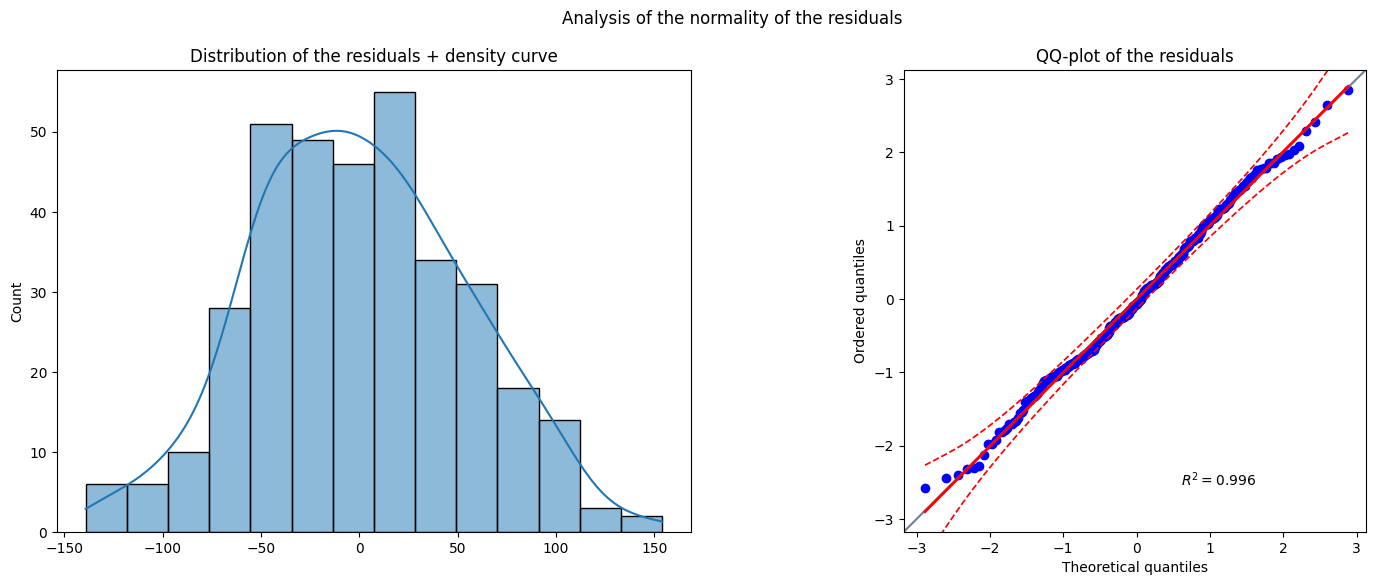


 **Tests d'adéquation à la loi normale - Normality Tests**
alpha = 0.05
                 Test  statistic   p_value     interpretation
0  Kolmogorov-Smirnov   0.036637  0.716268  fail to reject H0
1             Shapiro   0.995469  0.398029  fail to reject H0

Conclusion:
 - As the p_value > 0.05 for Kolmogorov-Smirnov test, so we do not reject H0 and assume that residuals distribution IS normal


In [42]:
# **Normality of residuals**
# Visualise the residuals
fig, axes = plt.subplots(1,2, figsize=(18,6))
sns.histplot(residuals, ax=axes[0], kde = True)
axes[0].set_title("Distribution of the residuals + density curve")

axes[1] = pingouin.qqplot(residuals, dist='norm')
axes[1].set_title("QQ-plot of the residuals")
plt.suptitle("Analysis of the normality of the residuals")
plt.show()

# Computing the stats
mu = residuals.mean()
sigma = np.std(residuals)
n_var = len(residuals)

# Perform statistical test
result, conclusion = test_stats_normality(df_residual, 'residuals' , mu, sigma, 0.05)
print(result)
print(conclusion)

In [43]:
pd.DataFrame({'residuals':residuals, 'fitted_values':y_pred})

,residuals,fitted_values
17,-41.981679,185.981679
66,8.897694,141.102306
137,42.923865,237.076135
245,18.858043,106.141957
31,-7.662232,66.662232
...,...,...
106,57.009286,76.990714
270,8.290019,193.709981
348,25.852120,122.147880
435,-57.171986,121.171986


Index([102, 359, 92], dtype='int64')


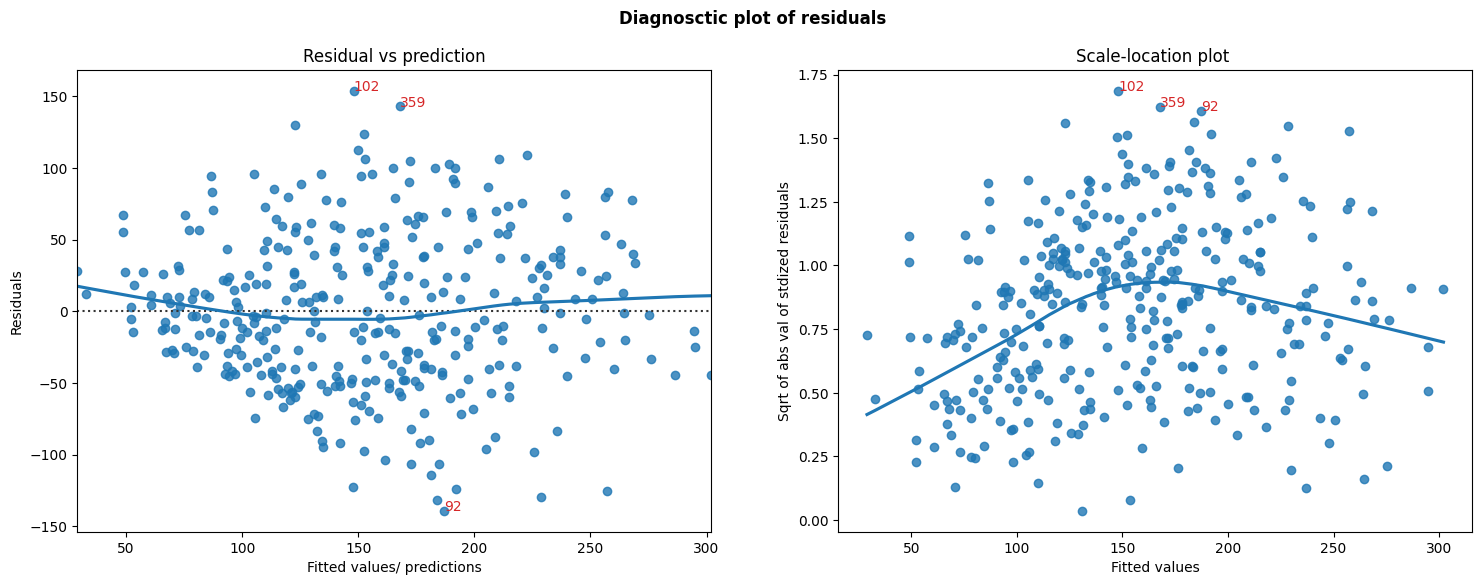

In [44]:
# **Diagnostic plots**
fig, axes = plt.subplots(1,2, figsize=(18,6))

# Residual vs prediction
sns.residplot(x='fitted_values', y="residuals", data = pd.DataFrame({'residuals':residuals, 'fitted_values':y_pred}), lowess=True, ax=axes[0])
axes[0].set_xlabel("Fitted values/ predictions")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residual vs prediction")
# annotations
residual_abs = np.abs(residuals)
#abs_resid = np.flip(np.argsort(residual_abs), 0)
abs_resid = residual_abs.sort_values(ascending=False).index
abs_resid_top_3 = abs_resid[:3]
for i in abs_resid_top_3:
    axes[0].annotate(  i, xy=(y_pred[i], residuals[i]), color='C3')

# Scale - location plot 
# source: https://www.statsmodels.org/dev/examples/notebooks/generated/linear_regression_diagnostics_plots.html
rl_model_norm_residuals = rl_model.get_influence().resid_studentized_internal
rl_model_norm_residuals_abs_sqrt = np.sqrt(np.abs(rl_model_norm_residuals))
sns.regplot(x=y_pred, y=rl_model_norm_residuals_abs_sqrt, ci=None, lowess=True, ax=axes[1])

# annotations 
df_rl_model_norm_residuals_abs_sqrt = pd.Series(rl_model_norm_residuals_abs_sqrt, index = residuals.index)
abs_sq_norm_resid = df_rl_model_norm_residuals_abs_sqrt.sort_values(ascending=False).index
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
print(abs_sq_norm_resid_top_3)
for i in abs_sq_norm_resid_top_3:
    axes[1].annotate( i, xy=(y_pred[i], df_rl_model_norm_residuals_abs_sqrt[i]), color='C3')
    
axes[1].set_xlabel("Fitted values")
axes[1].set_ylabel("Sqrt of abs val of stdized residuals")
axes[1].set_title("Scale-location plot ")

plt.suptitle("Diagnosctic plot of residuals", fontweight="bold")
plt.savefig("../images/222_diagnosctic_plot_of_residuals.png", dpi=300, bbox_inches='tight') #Save the image
plt.show()

- In the "residual vs prediction plot",the lowess line is quite linear, at least most of the time. But for the lowest and the highest values it's not the case
- In the "scale-loc plot", we can notice that the line change with the fitted value. So the residuals seems to be heterodastics

In [45]:
residuals

17     -41.981679
66       8.897694
137     42.923865
245     18.858043
31      -7.662232
          ...    
106     57.009286
270      8.290019
348     25.852120
435    -57.171986
102    153.931459
Length: 353, dtype: float64

In [46]:
# **Check if the variance of the residuals remains constant**
from statsmodels.stats.diagnostic import het_breuschpagan
# Homoscedasticity
_, pval, _, _ = het_breuschpagan(residuals, X_train)
print(pval)

0.049810611218243796


- The residuals are heteroscedastic

In [47]:
# Independance
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(residuals)
print(dw)

1.8189341917843882


- the statisque of durbin_watson is near to 2, so the residuals are independants

The hypotheses of linear regression are not validated, which means that we cannot infer the coefficients of the model to the entire population. Moreover, given the poor performance of the model (an R_squared 0.463 on the test set), we also conclude that linear regression is not the model adapted to the data. Moreover, reading the scatterplot between y and each of the explanatory variables, we could have already suspected this because very few of them present a linear relationship with y.

## Conclusion of the Statistical Modelisation

**Conclusion**  
We trained a linear regression to model the progression of diabetes y based on clinical variables.
- First, using backward elimination, we removed the 'age' and then the 'glu' variables to obtain a model where all remaining coefficients were significant (p < 0.05). And, this did not significantly affect the model's performance.
- Indeed, only 46% of the variance is explained by the model (R_squared = 0.463).
- Furthermore, residual analysis indicates that the assumptions of linear regression are not completly met, particularly homoscedasticity. This means that we cannot infer these coefficients to the entire population.
- Furthermore, several variables do not show a clear linear relationship with y (see EDA), which calls into question the relevance of a simple linear model to capture the complexity of the data.

# Predictive modelisation

While linear regression allows us to identify statistically significant relationships between clinical variables and diabetes progression, its limited predictive power and assumption violations highlight the need for more flexible models. We therefore transition to machine learning approaches better suited to capturing complex patterns and improving predictive accuracy.


In [48]:
# Define the feature set for the prediction models
print(f"All variables: {df.columns.values}\n")
print(f"Variables available as inputs {original_variables}\n")
print(f"Previous feature_set, without high vif factor: {feature_set}")

All variables: ['age' 'sex' 'bmi' 'bp' 'tc' 'ldl' 'hdl' 'tch' 'ltg' 'glu' 'y' 'bmi_cat'
 'bmi_log' 'bmi_cat2' 'is_obese']

Variables available as inputs ['age', 'sex', 'bmi', 'bp', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']

Previous feature_set, without high vif factor: ['age', 'sex', 'bmi', 'bp', 'tc', 'hdl', 'ltg', 'glu']


- As we will use linear model in the benchmark, we still use 'feature_set' without too high vif factor

In [49]:
# Create a table to compare result
results = []
benchmark_table = pd.DataFrame(columns= ["model","RMSE Train","CV Mean RMSE", "CV Std RMSE"])
benchmark_table

,model,RMSE Train,CV Mean RMSE,CV Std RMSE


## Simple Linear Regression (Baseline model)

In [50]:
from sklearn.linear_model import LinearRegression

# Intanciate the model as Simple Linear Regressor: slr 
slr = LinearRegression()

# Data 
X = df[['bmi']]
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
kf = KFold(n_splits = 4, shuffle = True, random_state = 42) 

# Training
slr.fit(X_train, y_train)

# Evaluation on training set 
y_pred_train = slr.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
print("RMSE train: ", rmse_train,"\n")

# Evaluate the model on the entire trainset and with Cross Validation from the train set
slr_rmse, slr_cv_mean_rsme, slr_cv_std_rmse = fit_and_evaluate_model_with_cv("Simple Linear Regression", slr, X_train, y_train, kf)


# Update models comparaison table 
benchmark_table = update_model_results(benchmark_table, "Simple Linear Regression", slr_rmse, slr_cv_mean_rsme, slr_cv_std_rmse)

RMSE train:  62.081500079136454 

Simple linear regression: Fitting and Evaluation on the entire train set and with Cross validation (from the trainset)
R2 train = 0.366     | MAE Train  = 51.380    | RMSE Train = 62.082
R2 mean (CV) = 0.349 | MAE mean (CV) = 51.684 | RMSE mean (CV)  = 62.340
RMSE CV score:
 - cv rmse score on training folds: [63.34578418 61.77846243 62.51666361 60.47021095] | std: 1.056 
 - cv rmse score test folds: [58.56708413 63.10630957 60.78627075 66.90233469] | std: 3.084


- The simple linear regression with only 1 feature input ("bmi") has bad perfomances, with a high RMSE value = 62. 
- But the results on the training set is realy similar to the CV results, so model is as bad on the training folds as test folds

## Data slipting & KFold

In [51]:
# Data 
print("Feature set for the other models: ", feature_set) 
X = df[feature_set]
y = df['y']
print("X shape: ", X.shape)

# 1. Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

# 2. Create the fold 
kf = KFold(n_splits = 4, shuffle = True, random_state = 42) 

Feature set for the other models:  ['age', 'sex', 'bmi', 'bp', 'tc', 'hdl', 'ltg', 'glu']
X shape:  (442, 8)
X_train shape:  (353, 8)
X_test shape:  (89, 8)


## Linear Regression

In [52]:
# Intanciate the model as Linear Regressor: lr 
lr = LinearRegression()

# Training
lr.fit(X_train, y_train)

# Evaluation on training set 
y_pred_train = lr.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
print(f"RMSE train: {round(rmse_train,2)} \n")

# Evaluate the model on the entire trainset and with Cross Validation from the train set
lr_rmse, lr_cv_mean_rsme, lr_cv_std_rmse = fit_and_evaluate_model_with_cv("Linear Regression", lr, X_train, y_train, kf)
results = ["Linear Regression", lr_rmse, lr_cv_mean_rsme, lr_cv_std_rmse]

# # Update models comparaison table 
benchmark_table = update_model_results(benchmark_table, *results)

RMSE train: 53.85 

Linear regression: Fitting and Evaluation on the entire train set and with Cross validation (from the trainset)
R2 train = 0.523     | MAE Train  = 43.719    | RMSE Train = 53.851
R2 mean (CV) = 0.482 | MAE mean (CV) = 45.357 | RMSE mean (CV)  = 55.681
RMSE CV score:
 - cv rmse score on training folds: [54.94071135 52.77800063 54.30792176 52.24701558] | std: 1.096 
 - cv rmse score test folds: [51.27740604 57.94263397 53.49723455 60.00729472] | std: 3.464


- Adding more features into the model improve a lot the performances. The RMSE varies from 62 to 56, but the result still bad. 
- And this linear regression barely manages to explain half the variance from the features.
- Note differencies of RSME between the entier train set and the cv, still close with this linear regression but there is still a difference, that means the multinomiale linar regression tend to generalize less than simple linear regression

In [53]:
benchmark_table

,model,RMSE Train,CV Mean RMSE,CV Std RMSE
0,Simple Linear Regression,62.082,62.340,3.084
1,Linear Regression,53.851,55.681,3.464


## Ridge and Lasso

In [54]:
# Ridge + Lasso : Pipeline + CV  with loop
results = []
scorings = {'r2':'r2', 'neg_mae':'neg_mean_absolute_error', 'neg_rmse':'neg_root_mean_squared_error'}
print(f"Feature_set usued for the training: {X.columns.values}")
# 1. Split 
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 2. Create the fold 
#kf = KFold(n_splits = 4, shuffle = True, random_state = 42) 

# 3. Training with Cross Validation
for name, model in zip(("Ridge","Lasso"),(Ridge(),Lasso())):
    print(f"\n{name.capitalize()} evalutation on the train set-------------------------------------------------")
    # Create a pipeline
    steps = [("scaler",StandardScaler()), (name, model)] 
    pipeline = Pipeline(steps)
    
    # Predict and evalute the model on Train set 
    print(f"Evaluate the {name} model on training set:")
    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    r2_score_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    print(f"- {name} | R2_train: {r2_score_train:.3f} | MAE train: {mae_train:.3f} | RMSE train: {rmse_train:.3f} ")  

    # Evalute model with CV  (on train set) 
    print(f"Evaluate the {name} model with cross validation:")
    # cv = cross_val_score(pipeline, X_train, y_train, cv = kf, scoring="r2")
    cv_results = cross_validate(pipeline, X_train, y_train, cv=kf, scoring= scorings)
    #print(cv_results)
    cv_r2 = cv_results['test_r2']
    cv_mae = -cv_results['test_neg_mae']
    cv_rmse = (cv_results['test_neg_rmse']*(-1))
    #print(cv_mae)
    print(f"- {name} | Mean R² (CV): {cv_r2.mean():.3f} | Mean MAE (CV): {cv_mae.mean():.3f} | Mean RMSE (CV): {cv_rmse.mean():.3f} | Std RMSE (CV): {cv_rmse.std():.3f}")
    print(f"- RMSE of each fold: {cv_rmse} | RMSE std {cv_rmse.std():.3f}")
    results.append([name, round(rmse_train,2), round(cv_rmse.mean(),2), round(cv_rmse.std(),2)])
    # Update models comparaison table
    benchmark_table = update_model_results(benchmark_table, name, round(rmse_train,2), round(cv_rmse.mean(),2), round(cv_rmse.std(),2))
results

Feature_set usued for the training: ['age' 'sex' 'bmi' 'bp' 'tc' 'hdl' 'ltg' 'glu']

Ridge evalutation on the train set-------------------------------------------------
Evaluate the Ridge model on training set:
- Ridge | R2_train: 0.523 | MAE train: 43.722 | RMSE train: 53.851 
Evaluate the Ridge model with cross validation:
- Ridge | Mean R² (CV): 0.482 | Mean MAE (CV): 45.352 | Mean RMSE (CV): 55.669 | Std RMSE (CV): 3.454
- RMSE of each fold: [51.26464009 57.96345492 53.49605938 59.95080386] | RMSE std 3.454

Lasso evalutation on the train set-------------------------------------------------
Evaluate the Lasso model on training set:
- Lasso | R2_train: 0.521 | MAE train: 43.890 | RMSE train: 53.931 
Evaluate the Lasso model with cross validation:
- Lasso | Mean R² (CV): 0.485 | Mean MAE (CV): 45.325 | Mean RMSE (CV): 55.508 | Std RMSE (CV): 3.201
- RMSE of each fold: [51.12545791 58.28873783 53.78293297 58.8351217 ] | RMSE std 3.201


[['Ridge', 53.85, np.float64(55.67), np.float64(3.45)],
 ['Lasso', 53.93, np.float64(55.51), np.float64(3.2)]]

- The metrics of Ridge and Lass are really close to the linear regression. 
- The best model so far is Lasso with a cross validation Mean RMSE at 55.5 

In [55]:
benchmark_table

,model,RMSE Train,CV Mean RMSE,CV Std RMSE
0,Simple Linear Regression,62.082,62.340,3.084
1,Linear Regression,53.851,55.681,3.464
2,Ridge,53.850,55.670,3.450
3,Lasso,53.930,55.510,3.200


In [56]:
print(name)
print(model.get_params())

Lasso
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


## LightGBM

In [57]:
# Intanciate the model LightGBM Regressor as lgbm_reg
lgbm_reg = lgb.LGBMRegressor(
    #n_estimators = 100,
    #learning_rate = 0.1
    verbose=-1
)
# Training
lgbm_reg.fit(X_train, y_train)

# Evaluation on training set 
y_pred_train = lgbm_reg.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
print(f"RMSE train: {round(rmse_train,2)} \n")

# Train & Evaluate the model on the entire trainset and with Cross Validation from the train 
results = fit_and_evaluate_model_with_cv("LightGBM Regressor", lgbm_reg, X_train, y_train, kf)

# # Update models comparaison table 
benchmark_table = update_model_results(benchmark_table,"LightGBM Regressor", *results)

RMSE train: 22.55 

Lightgbm regressor: Fitting and Evaluation on the entire train set and with Cross validation (from the trainset)
R2 train = 0.916     | MAE Train  = 17.618    | RMSE Train = 22.547
R2 mean (CV) = 0.389 | MAE mean (CV) = 47.887 | RMSE mean (CV)  = 60.288
RMSE CV score:
 - cv rmse score on training folds: [25.00337627 24.49533392 23.28681766 22.69232863] | std: 0.922 
 - cv rmse score test folds: [55.48500703 59.49466278 61.0920664  65.08013519] | std: 3.439


In [58]:
benchmark_table

,model,RMSE Train,CV Mean RMSE,CV Std RMSE
0,Simple Linear Regression,62.082,62.340,3.084
1,Linear Regression,53.851,55.681,3.464
2,Ridge,53.850,55.670,3.450
3,Lasso,53.930,55.510,3.200
4,LightGBM Regressor,22.547,60.288,3.439


LightGBM is quite bad:
- LightGBM dramatically overfits the training set.
- LightGBM achieves a slightly better CV RMSE (60.28) than the simple linear regression (62.34), but its performance on the training set (RMSE = 22.5) indicates strong overfitting.
- The model fails to generalize effectively, that suggests this model is too complex for the size and structure of the dataset.

## Random Forest

In [59]:
# ** Random Forest ** 
# Intantiate the model 
rf = RandomForestRegressor(n_estimators=100, max_depth=20)

# Fit 
rf.fit(X_train, y_train)
# Predict & evaluate the model on Test set 
y_pred_test = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
print("Evaluate the model on Test set:")
print("\t mae: ", mae)
print("\t rmse:", rmse)
print("\t r2:", r2)

# Fit & Evaluat the model 
rf_rmse_train, rf_cv_mean_rmse, rf_cv_std_rmse = fit_and_evaluate_model_with_cv("random_forest", rf, X_train, y_train, kf)

# # Update models comparaison table 
benchmark_table = update_model_results(benchmark_table,"Random Forest", rf_rmse_train, rf_cv_mean_rmse, rf_cv_std_rmse)

Evaluate the model on Test set:
	 mae:  45.36213483146067
	 rmse: 55.57847779835305
	 r2: 0.4169726838709584
Random_forest: Fitting and Evaluation on the entire train set and with Cross validation (from the trainset)
R2 train = 0.925     | MAE Train  = 17.392    | RMSE Train = 21.349
R2 mean (CV) = 0.440 | MAE mean (CV) = 47.433 | RMSE mean (CV)  = 57.843
RMSE CV score:
 - cv rmse score on training folds: [22.09552776 21.98069348 22.09858078 21.41139698] | std: 0.284 
 - cv rmse score test folds: [54.58630754 58.87682468 56.4506588  61.45911526] | std: 2.583


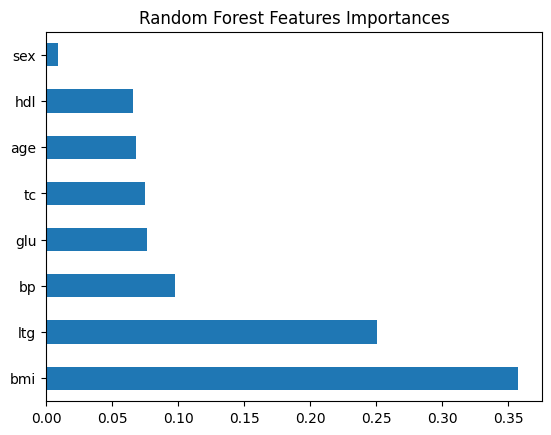

In [60]:
# Print features importance
plt.title("Random Forest Features Importances")
(pd.Series(rf.feature_importances_, index=X_train.columns)).nlargest(10).plot(kind='barh')
plt.show()

In [61]:
print(feature_set)
rf.feature_importances_

['age', 'sex', 'bmi', 'bp', 'tc', 'hdl', 'ltg', 'glu']


array([0.06805031, 0.00932224, 0.35765727, 0.09750825, 0.07509544,
       0.06577191, 0.25038888, 0.07620571])

- Random Forest shows strong overfitting, with a large RMSE gap between training (≈ 22) and validation folds (≈ 58). 
- This is confirmed on closer examination on the CV results, which data is fitted on each iteration on the training folds, and evaluate as the training set, on training folds (used for the fit) and also on the testing folds. The cv rmse on training folds are much lower (around 22) than the rmse calculate on the test fœolds (around 55/60).
- The 2 most important features are "bmi" and "ltg", which also are the variables with the highest linear correlation with the target

## Conclusion of the benchmark

In [62]:
benchmark_table

,model,RMSE Train,CV Mean RMSE,CV Std RMSE
0,Simple Linear Regression,62.082,62.340,3.084
1,Linear Regression,53.851,55.681,3.464
2,Ridge,53.850,55.670,3.450
3,Lasso,53.930,55.510,3.200
4,LightGBM Regressor,22.547,60.288,3.439
5,Random Forest,21.349,57.843,2.583


To conclude the model benchmark part, we notice that any of this out of the box models have a good performances.  
- The ensemble models tend to overfit because, we when train the model the entire training set and evaluate it on the same training set, the RMSE this much lower for LightGBM and Random Forest (around 22) than all the other linear models (about 53/60).
- The worst model (base on the cross validation rmse) are the simple linear regression because using only the "bmi" is to light to capture the evolution of the diabet y. And The LightGBM because it's overfit a lot and may is to complex for this sample dataset (442 rows)
- The best model so far is Lasso Regression, we will fine tuned it and the next section.

## Hyperparameter tuning

In [63]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
# Create step 
scaler = StandardScaler()
lasso = Lasso(random_state=2025)

# Pipeline
pipeline = make_pipeline(scaler, lasso)

# Create 3 Folds 
kf = KFold(n_splits=3, shuffle = True, random_state = 42)

# GridSearch 
params = {
    'lasso__alpha': [0.01,0.1,1.0,1.9,2.0,2.1,2.2,3.0,10,100],
    'lasso__fit_intercept':[True, False],
    'lasso__max_iter': [100,500,1000,1500,2000],
    'lasso__warm_start':[True,False],
    'lasso__tol': [0.001,0.0001,0.00001],
    'lasso__selection': ['cyclic','random']
}

grid_lasso = GridSearchCV(
    estimator = pipeline, 
    param_grid = params,
    cv=kf,
    scoring = 'neg_root_mean_squared_error'
)
grid_lasso

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso', Lasso(random_state=2025))]),
             param_grid={'lasso__alpha': [0.01, 0.1, 1.0, 1.9, 2.0, 2.1, 2.2,
                                          3.0, 10, 100],
                         'lasso__fit_intercept': [True, False],
                         'lasso__max_iter': [100, 500, 1000, 1500, 2000],
                         'lasso__selection': ['cyclic', 'random'],
                         'lasso__tol': [0.001, 0.0001, 1e-05],
                         'lasso__warm_start': [True, False]},
             scoring='neg_root_mean_squared_error')

In [64]:
# Fit 
grid_lasso.fit(X_train, y_train)
display(grid_lasso)
print("Best estimator: \n", grid_lasso.best_estimator_)
print("Best param: \n", grid_lasso.best_params_)
print("Best RMSE: \n", -grid_lasso.best_score_)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso', Lasso(random_state=2025))]),
             param_grid={'lasso__alpha': [0.01, 0.1, 1.0, 1.9, 2.0, 2.1, 2.2,
                                          3.0, 10, 100],
                         'lasso__fit_intercept': [True, False],
                         'lasso__max_iter': [100, 500, 1000, 1500, 2000],
                         'lasso__selection': ['cyclic', 'random'],
                         'lasso__tol': [0.001, 0.0001, 1e-05],
                         'lasso__warm_start': [True, False]},
             scoring='neg_root_mean_squared_error')

Best estimator: 
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso',
                 Lasso(alpha=2.1, max_iter=100, random_state=2025,
                       warm_start=True))])
Best param: 
 {'lasso__alpha': 2.1, 'lasso__fit_intercept': True, 'lasso__max_iter': 100, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0001, 'lasso__warm_start': True}
Best RMSE: 
 55.5614178674113


In [65]:
# Analyse the best models 
pd.DataFrame.from_dict(grid_lasso.cv_results_).sort_values(by='mean_test_score', ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,param_lasso__fit_intercept,param_lasso__max_iter,param_lasso__selection,param_lasso__tol,param_lasso__warm_start,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
602,0.002579,0.000105,0.001381,0.000066,2.1,True,100,cyclic,0.0001,True,"{'lasso__alpha': 2.1, 'lasso__fit_intercept': ...",-55.6935,-53.941454,-57.049299,-55.561418,1.272206,1
603,0.002455,0.000010,0.001313,0.000012,2.1,True,100,cyclic,0.0001,False,"{'lasso__alpha': 2.1, 'lasso__fit_intercept': ...",-55.6935,-53.941454,-57.049299,-55.561418,1.272206,1
638,0.002584,0.000194,0.001337,0.000050,2.1,True,1500,cyclic,0.0001,True,"{'lasso__alpha': 2.1, 'lasso__fit_intercept': ...",-55.6935,-53.941454,-57.049299,-55.561418,1.272206,1
639,0.002895,0.000228,0.001511,0.000134,2.1,True,1500,cyclic,0.0001,False,"{'lasso__alpha': 2.1, 'lasso__fit_intercept': ...",-55.6935,-53.941454,-57.049299,-55.561418,1.272206,1
626,0.002464,0.000017,0.001346,0.000068,2.1,True,1000,cyclic,0.0001,True,"{'lasso__alpha': 2.1, 'lasso__fit_intercept': ...",-55.6935,-53.941454,-57.049299,-55.561418,1.272206,1
627,0.002503,0.000053,0.001319,0.000053,2.1,True,1000,cyclic,0.0001,False,"{'lasso__alpha': 2.1, 'lasso__fit_intercept': ...",-55.6935,-53.941454,-57.049299,-55.561418,1.272206,1
615,0.002658,0.000173,0.001391,0.000044,2.1,True,500,cyclic,0.0001,False,"{'lasso__alpha': 2.1, 'lasso__fit_intercept': ...",-55.6935,-53.941454,-57.049299,-55.561418,1.272206,1
614,0.002657,0.000155,0.001379,0.000032,2.1,True,500,cyclic,0.0001,True,"{'lasso__alpha': 2.1, 'lasso__fit_intercept': ...",-55.6935,-53.941454,-57.049299,-55.561418,1.272206,1
651,0.002556,0.000063,0.001385,0.000094,2.1,True,2000,cyclic,0.0001,False,"{'lasso__alpha': 2.1, 'lasso__fit_intercept': ...",-55.6935,-53.941454,-57.049299,-55.561418,1.272206,1
650,0.002554,0.000097,0.001321,0.000025,2.1,True,2000,cyclic,0.0001,True,"{'lasso__alpha': 2.1, 'lasso__fit_intercept': ...",-55.6935,-53.941454,-57.049299,-55.561418,1.272206,1


- We notice that the 8 best models have all the same mean rmse and alpha = 1, fit_intercept=True, param_lasso_slection = random, tol = 0.0001.
- So, Among the best configurations, only the values of alpha, tol, and selection seem to play a significant role, even if the values of max_iter and warm_start vary.
- Moreover, the tuning just slighly improve the performance from a rmse of 55.51 to 54.58 
- So best model ({'lasso__alpha': 1.0, 'lasso__fit_intercept': True, 'lasso__max_iter': 100, 'lasso__selection': 'random', 'lasso__tol': 0.0001, 'lasso__warm_start': True}) will be used to predict the unseen data, y_test. 

**Apply this parameters on the model**

In [66]:
# Intenciate the model 
# Create step 
scaler = StandardScaler()
lasso = Lasso(
    alpha = 1.0,
    fit_intercept = True, 
    max_iter = 100,
    warm_start = True,
    tol = 0.0001,
    selection = 'random',
    random_state=2025)
#lasso = grid_lasso.best_estimator_[1]

# Pipeline
pipeline = make_pipeline(scaler, lasso)

# Fit 
pipeline.fit(X_train, y_train)

# Predict & Evaluate on the train set: 
y_pred_train = pipeline.predict(X_train)
r2_score_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
print(f"- Lasso | R2_train: {r2_score_train:.3f} | MAE train: {mae_train:.3f} | RMSE train: {rmse_train:.3f} ") 

# Predict 
y_pred = pipeline.predict(X_test)

# Evaluate 
r2_score_test = r2_score(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = root_mean_squared_error(y_test, y_pred)
print(f"- Lasso | R2_test: {r2_score_test:.3f}  | MAE test: {mae_test:.3f}  | RMSE train: {rmse_test:.3f} ")  

- Lasso | R2_train: 0.521 | MAE train: 43.889 | RMSE train: 53.931 
- Lasso | R2_test: 0.468  | MAE test: 42.776  | RMSE train: 53.074 


- After fine tuning, with the best model we obtain an rsme = 56 on the validation data, which isn't bad, but it's not great either.

In [67]:
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 100,
 'positive': False,
 'precompute': False,
 'random_state': 2025,
 'selection': 'random',
 'tol': 0.0001,
 'warm_start': True}

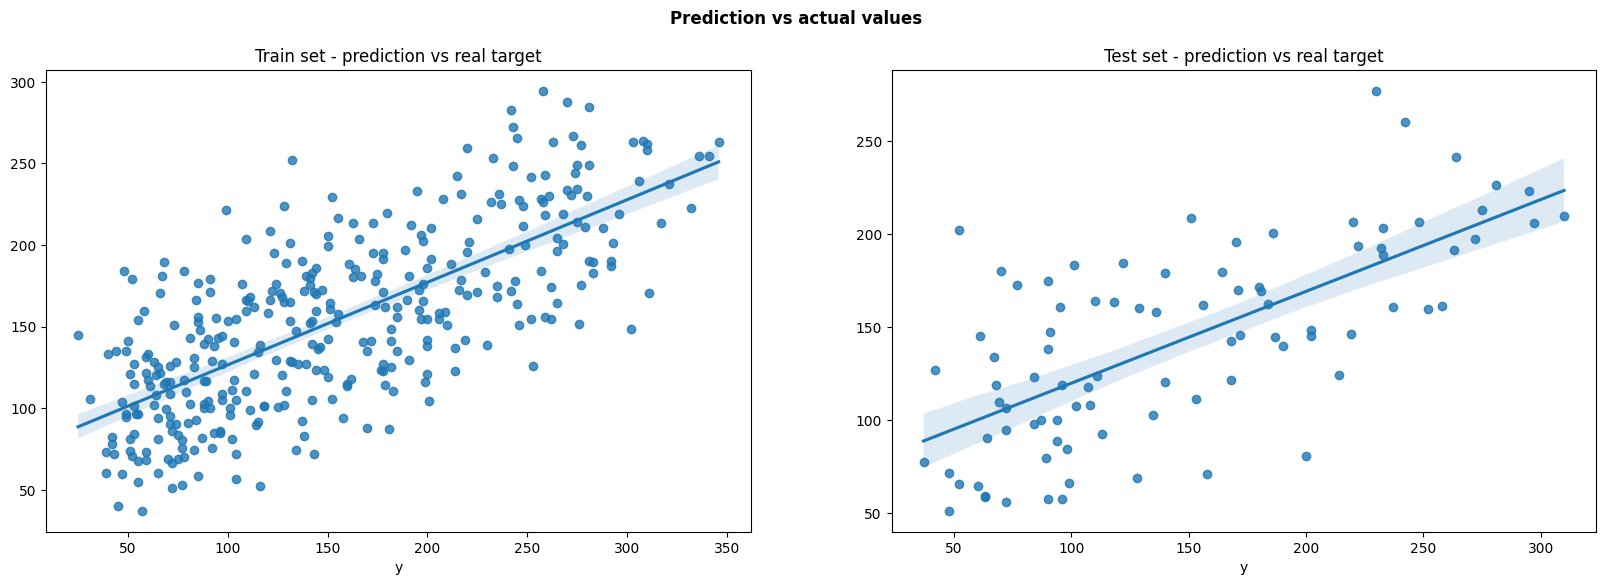

In [68]:
fig, axes = plt.subplots(1,2, figsize=(20,6))

# Visualization of the Lasso prediction 
sns.regplot(x=y_train, y=y_pred_train, ax=axes[0])
sns.regplot(x=y_test, y=y_pred, ax=axes[1])

axes[0].set_title("Train set - prediction vs real target")
axes[1].set_title("Test set - prediction vs real target")

plt.suptitle("Prediction vs actual values", fontweight="bold")
plt.show()

**Feature Importance**

In [69]:
# Get the model from the pipeline 
lasso = pipeline.named_steps['lasso']

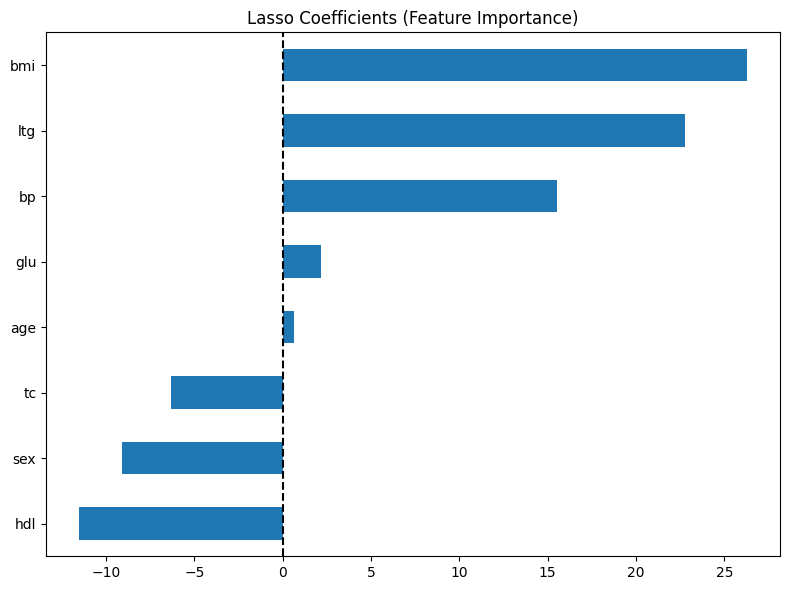

In [70]:
# Get the coefficients 
#lasso = pipeline.named_steps['lasso']
coefs = pd.Series(lasso.coef_, index=X_train.columns)

# Visualize them
coefs = coefs.sort_values()
plt.figure(figsize=(8,6))
coefs.plot(kind='barh')
plt.title("Lasso Coefficients (Feature Importance)")
plt.axvline(x=0, color='k', linestyle='--')
plt.tight_layout()
plt.show()

[ 0.02727996  1.63496888 12.07784095  4.47766581  0.85508809  2.64994426
  9.30416367  0.17783101]


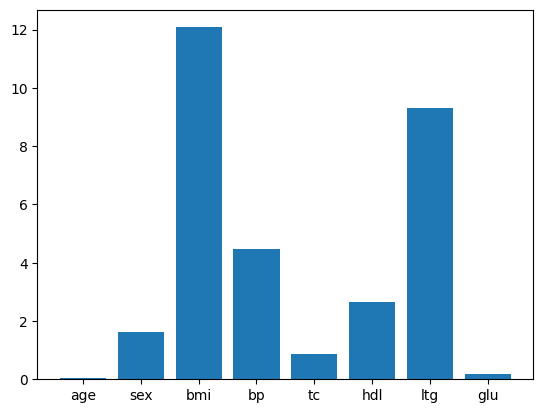

In [71]:
# Permuatation importance
result = permutation_importance(pipeline, X_train, y_train, n_repeats=10, random_state=42, scoring = 'neg_root_mean_squared_error')
print(result.importances_mean)

plt.bar(X_train.columns, result.importances_mean)
plt.show()

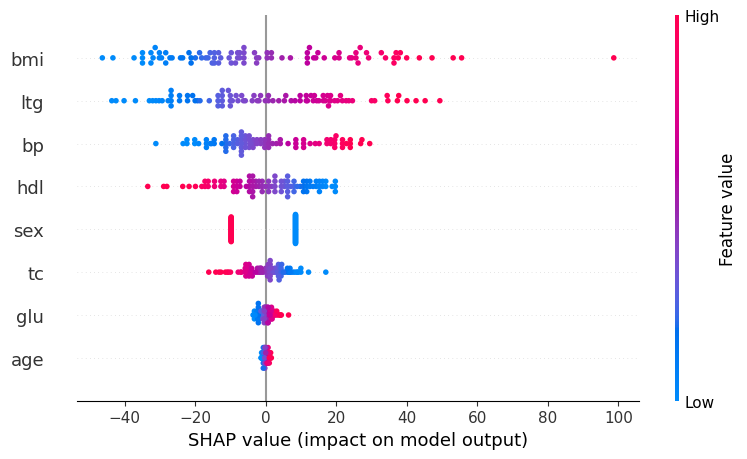

In [72]:
# Feature importance with SHAP value 

# Get pipeline step
scaler = pipeline.named_steps['standardscaler']
lasso = pipeline.named_steps['lasso']

# Scaled the training set 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Setting up SHAP Explainer
explainer = shap.Explainer(lasso, X_test_scaled)
shap_values = explainer(X_test_scaled)

# Display Summary Plot on X_test
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

**Conclusion**  
Analysis of the Lasso model coefficients, significance by permutation, and SHAP values all converge towards the same reading: the variables bmi, ltg and bp are the most decisive in predicting diabetes progression. Conversely, variables such as hdl, tc and sex have a negative impact on the target variable.
These 3 methods provide a better understanding of the clinical levers associated with disease progression in this dataset.